# GUC K-nearest neighbor Classification

### Import packages and data set
#### Import the "Classified data" file 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
df=pd.read_csv("Classified Data")
df.drop("Index",inplace=True, axis=1)
df.head()

WTT       PTI       EQW       SBI       LQE       QWG       FDJ  \
0  0.913917  1.162073  0.567946  0.755464  0.780862  0.352608  0.759697   
1  0.635632  1.003722  0.535342  0.825645  0.924109  0.648450  0.675334   
2  0.721360  1.201493  0.921990  0.855595  1.526629  0.720781  1.626351   
3  1.234204  1.386726  0.653046  0.825624  1.142504  0.875128  1.409708   
4  1.279491  0.949750  0.627280  0.668976  1.232537  0.703727  1.115596   

        PJF       HQE       NXJ  TARGET CLASS  
0  0.643798  0.879422  1.231409             1  
1  1.013546  0.621552  1.492702             0  
2  1.154483  0.957877  1.285597             0  
3  1.380003  1.522692  1.153093             1  
4  0.646691  1.463812  1.419167             1

### Scale the features using sklearn.preprocessing package

**Instantiate a scaler standardizing estimator**

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

**Fit the features data only to this estimator (leaving the TARGET CLASS column) and transform**

In [4]:
scaler.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [5]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

WTT       PTI       EQW       SBI       LQE       QWG       FDJ  \
0 -0.123542  0.185907 -0.913431  0.319629 -1.033637 -2.308375 -0.798951   
1 -1.084836 -0.430348 -1.025313  0.625388 -0.444847 -1.152706 -1.129797   
2 -0.788702  0.339318  0.301511  0.755873  2.031693 -0.870156  2.599818   
3  0.982841  1.060193 -0.621399  0.625299  0.452820 -0.267220  1.750208   
4  1.139275 -0.640392 -0.709819 -0.057175  0.822886 -0.936773  0.596782   

        PJF       HQE       NXJ  
0 -1.482368 -0.949719 -0.643314  
1 -0.202240 -1.828051  0.636759  
2  0.285707 -0.682494 -0.377850  
3  1.066491  1.241325 -1.026987  
4 -1.472352  1.040772  0.276510

### Train/Test split, model fit and prediction

In [6]:
from sklearn.model_selection import train_test_split
X = df_feat
y = df['TARGET CLASS']
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.50, random_state=101)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [8]:
pred = knn.predict(X_test)

### Evaluation of classification quality using Confusion Matrix

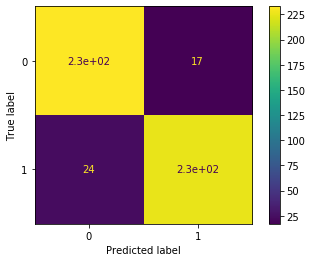

array([[233,  17],
       [ 24, 226]])

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test, pred,labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()
plt.show()
cm

***Print Misclassification error rate***

In [10]:
#since it is binary
tn, fp, fn, tp = confusion_matrix(y_test, pred,labels=knn.classes_).ravel()
total=tn+fp+fn+tp
error=(fp+fn)/total
error

0.082

In [11]:
#More general
i=0
error=[]
while i<len(cm):
    j=0
    while j<len(cm):
        if (i!=j):
            error.append(cm[i][j])
        j=j+1
    i=i+1
ErrorRate=sum(error)/len(y_test)  
ErrorRate


0.082

# Choosing 'k' using cross validation error
#### Plot the error rate vs. K Value

In [12]:
def calc_error(y_test, pred,labels):
    tn, fp, fn, tp = confusion_matrix(y_test, pred,labels=labels).ravel()
    total=tn+fp+fn+tp
    error=(fp+fn)/total
    return error

In [13]:
X_train_crossValid, X_test_acc, y_train_crossValid, y_test_acc = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.20, random_state=101)

In [14]:
#split X_train_crossValid
import math
MinMaxAvg_error=[]

X_train_model, X_CrossValidation, y_train_model, y_CrossValidation = train_test_split(X_train_crossValid,y_train_crossValid,
                                                   test_size=0.20, random_state=101)

start=int(math.sqrt(len(X_train_model)))
Neighbors=range(start,start+30)
for k in Neighbors:
    temp=[]
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(150):
        X_train_model, X_CrossValidation, y_train_model, y_CrossValidation = train_test_split(X_train_crossValid,y_train_crossValid,
                                                   test_size=0.20)
        knn.fit(X_train_model,y_train_model)
        pred = knn.predict(X_CrossValidation)
        temp.append(calc_error(y_CrossValidation, pred,knn.classes_)) 
        #print(temp)
    
    MinMaxAvg_error.append([min(temp),max(temp),sum(temp)/len(temp)])  

#MinMaxAvg_error 


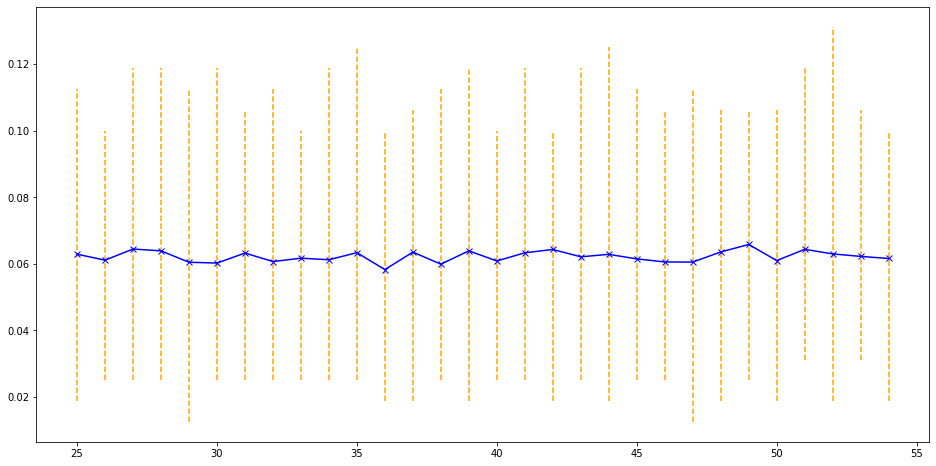

In [17]:
plt.figure(figsize=(16,8))
plt.plot((Neighbors,Neighbors),(np.array(MinMaxAvg_error)[:,0],np.array(MinMaxAvg_error)[:,1]),'--',color='orange')
plt.plot(Neighbors,np.array(MinMaxAvg_error)[:,2],  'bx-')

In [18]:
knn = KNeighborsClassifier(n_neighbors=36)
knn.fit(X_train_model,y_train_model)
pred = knn.predict(X_test_acc)
Accuracy=(1-calc_error(y_test_acc, pred,knn.classes_))*100
Accuracy       

95.0